In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('robot_dataset.csv')
task_sequence = df['Task_Type']

STATES = task_sequence.unique()
NUM_STATES = len(STATES)
print(f"States identified: {STATES}")

df_transitions = pd.DataFrame({
    'Current': task_sequence.iloc[:-1].values, 
    'Next': task_sequence.iloc[1:].values
})

frequency_matrix = pd.crosstab(df_transitions['Current'], df_transitions['Next'])

P_matrix = frequency_matrix.div(frequency_matrix.sum(axis=1), axis=0)

print("\n--- Calculated Transition Matrix (P) from Real Data ---")
print(P_matrix.round(4))

States identified: ['Inspection' 'Assembly' 'Welding' 'Painting']

--- Calculated Transition Matrix (P) from Real Data ---
Next        Assembly  Inspection  Painting  Welding
Current                                            
Assembly      0.2366      0.2214    0.2595   0.2824
Inspection    0.3153      0.1802    0.2342   0.2703
Painting      0.2698      0.2460    0.2222   0.2619
Welding       0.2443      0.2290    0.2901   0.2366


In [6]:

P_array = P_matrix.values 
NUM_STATES = len(STATES)


A = P_array.T - np.identity(NUM_STATES)
A[-1, :] = 1.0  

b = np.zeros(NUM_STATES)
b[-1] = 1.0

try:
    pi = np.linalg.solve(A, b)
    
    steady_state_df = pd.DataFrame(pi, index=STATES, columns=['Steady-State Probability'])
    
    print("\n--- Long-Term Steady-State Distribution (pi) ---")
    print(steady_state_df.round(4))
    print(f"\nTotal probability check: {pi.sum().round(9)}")
    
except np.linalg.LinAlgError:
    print("\nError: The Markov Chain may be reducible (not all states are reachable).")


--- Long-Term Steady-State Distribution (pi) ---
            Steady-State Probability
Inspection                    0.2644
Assembly                      0.2205
Welding                       0.2526
Painting                      0.2625

Total probability check: 1.0


In [7]:
N = 5

P_N = np.linalg.matrix_power(P_array, N)

print(f"\n--- {N}-Step Transition Matrix (P^{N}) ---")
P_N_df = pd.DataFrame(P_N, index=STATES, columns=STATES)
print(P_N_df.round(11))


--- 5-Step Transition Matrix (P^5) ---
            Inspection  Assembly   Welding  Painting
Inspection    0.264380  0.220522  0.252552  0.262546
Assembly      0.264379  0.220522  0.252553  0.262546
Welding       0.264379  0.220521  0.252553  0.262547
Painting      0.264380  0.220521  0.252552  0.262547


In [8]:

TIME_COLUMN = 'Processing_Time (s)' 

state_rewards_R = df.groupby('Task_Type')[TIME_COLUMN].mean().reindex(STATES)

print(f"\n--- Average {TIME_COLUMN} (Reward Vector R) ---")
print(state_rewards_R.round(2))


expected_processing_time_per_task = np.dot(pi, state_rewards_R.values)

print("\n--- Expected Long-Term Processing Time per Task Cycle ---")
print(f"The long-term average duration of one complete task cycle is: {expected_processing_time_per_task:.2f} seconds.")


--- Average Processing_Time (s) (Reward Vector R) ---
Task_Type
Inspection    58.80
Assembly      60.19
Welding       59.08
Painting      61.57
Name: Processing_Time (s), dtype: float64

--- Expected Long-Term Processing Time per Task Cycle ---
The long-term average duration of one complete task cycle is: 59.90 seconds.


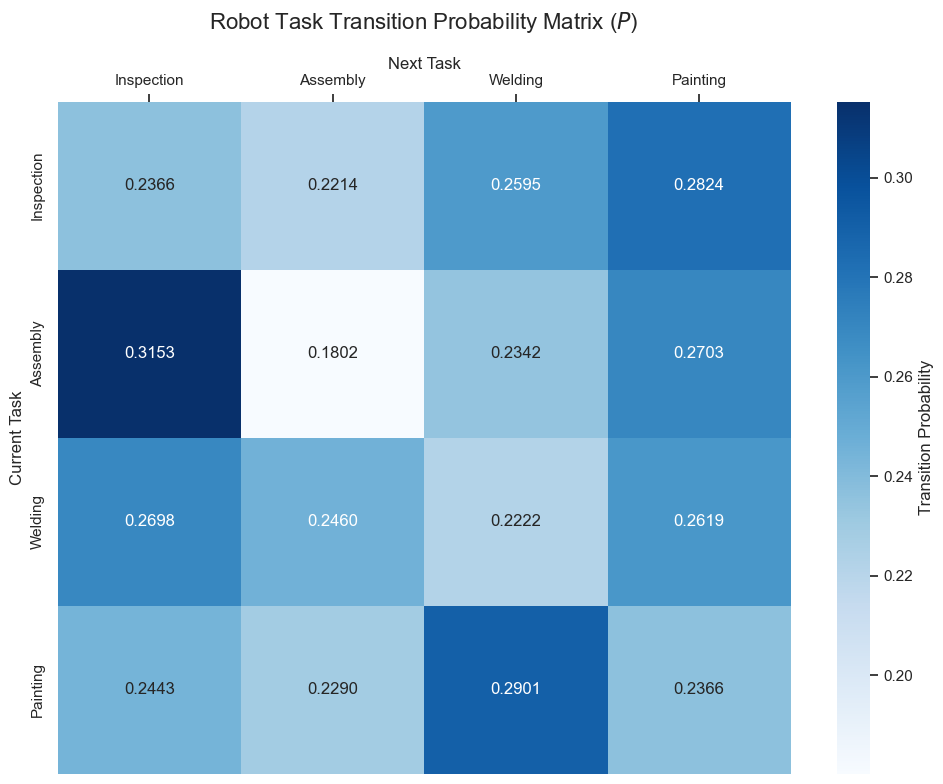

In [9]:
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(10, 8))
ax = sns.heatmap(P_matrix, annot=True, cmap="Blues", fmt=".4f",
            xticklabels=STATES, yticklabels=STATES,
            cbar_kws={'label': 'Transition Probability'})

plt.title('Robot Task Transition Probability Matrix ($P$)', fontsize=16, pad=20)

ax.xaxis.tick_top()                
ax.xaxis.set_label_position('top')  

plt.xlabel('Next Task', fontsize=12)
plt.ylabel('Current Task', fontsize=12)
plt.tight_layout()
plt.savefig('transition_heatmap.png', dpi=300)
plt.show()

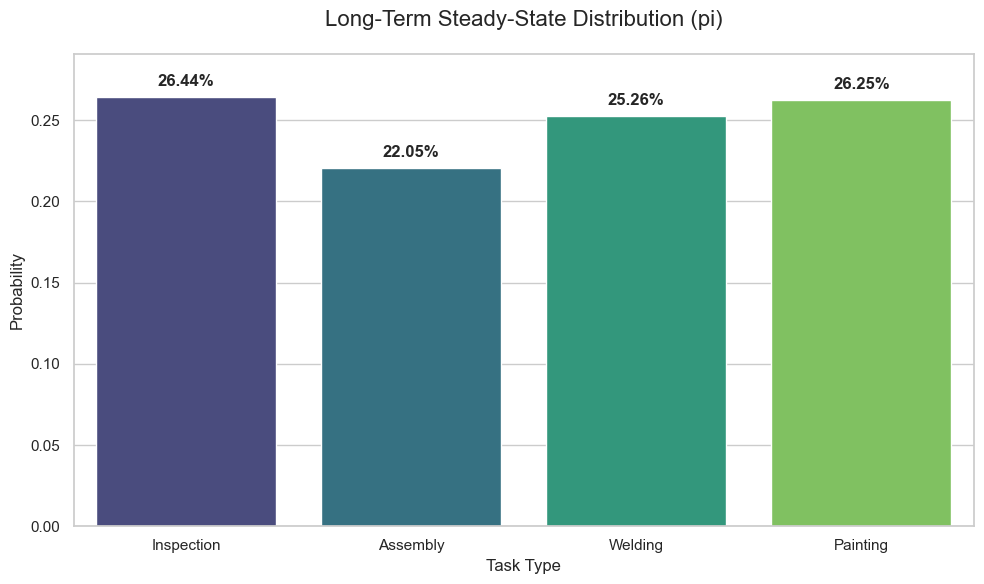

In [10]:
y_values = steady_state_df['Steady-State Probability']

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=STATES, y=y_values, hue=STATES, palette="viridis", dodge=False)

if barplot.legend_: barplot.legend_.remove() 

plt.title('Long-Term Steady-State Distribution (pi)', fontsize=16, pad=20)
plt.ylabel('Probability', fontsize=12)
plt.xlabel('Task Type', fontsize=12)

max_prob = y_values.max()
plt.ylim(0, max_prob * 1.1)


for i, v in enumerate(y_values):
    barplot.text(i, v + 0.005, f'{v:.2%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('steady_state_distribution.png', dpi=300)
plt.show()

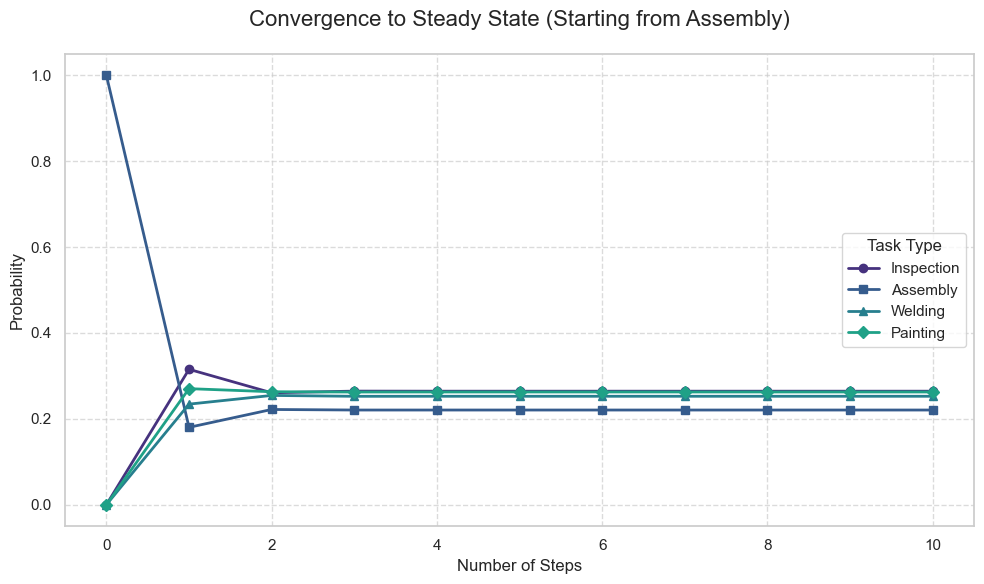

In [11]:
steps = 10
history = np.zeros((steps + 1, NUM_STATES))

current_state = np.zeros(NUM_STATES)


start_index = np.where(STATES == 'Assembly')[0][0]
current_state[start_index] = 1.0

history[0] = current_state

for i in range(1, steps + 1):
    current_state = np.dot(current_state, P_array) 
    history[i] = current_state

# --- Plotting ---
plt.figure(figsize=(10, 6))
markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p']

for i, state in enumerate(STATES):
    plt.plot(range(steps + 1), history[:, i], label=state, 
             marker=markers[i % len(markers)], linewidth=2)

plt.title('Convergence to Steady State (Starting from Assembly)', fontsize=16, pad=20)
plt.xlabel('Number of Steps', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.legend(title="Task Type", loc='center right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('convergence_plot.png', dpi=300)
plt.show()

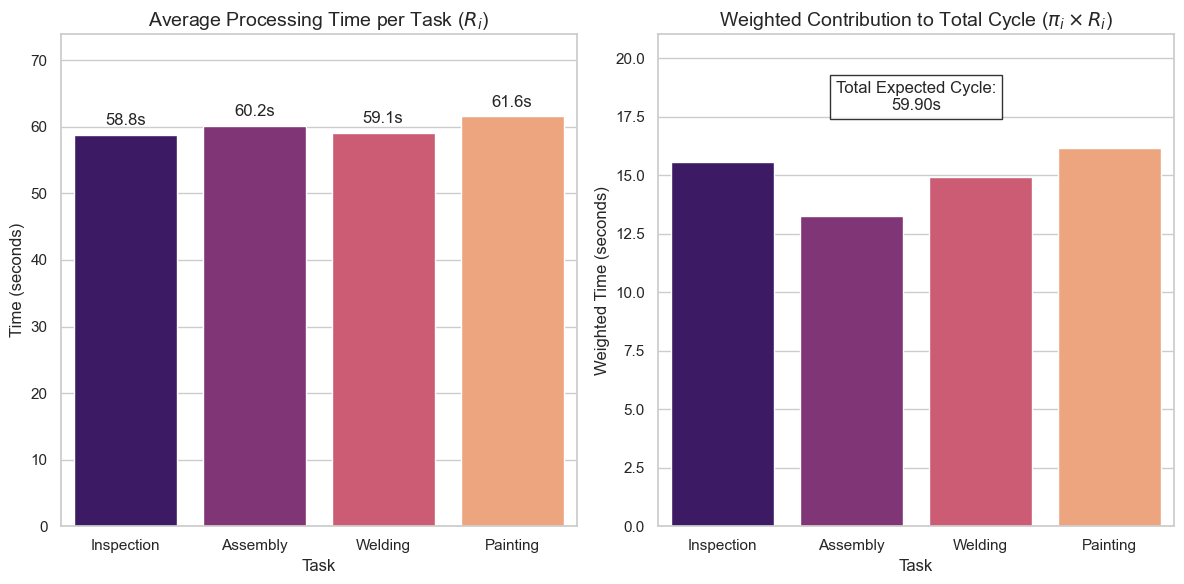

In [12]:
R_values = state_rewards_R.values  
pi_values = pi                     

mrp_df = pd.DataFrame({
    'Task': STATES,
    'Avg Time (s)': R_values,
    'Contribution (s)': pi_values * R_values
})

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
bp1 = sns.barplot(x='Task', y='Avg Time (s)', data=mrp_df, hue='Task', palette="magma", dodge=False)
if bp1.legend_: bp1.legend_.remove()

plt.title(r'Average Processing Time per Task ($R_i$)', fontsize=14) 
plt.ylabel('Time (seconds)')
plt.ylim(0, R_values.max() * 1.2) 

for i, v in enumerate(R_values):
    plt.text(i, v + 1, f'{v:.1f}s', ha='center', va='bottom')

plt.subplot(1, 2, 2)
bp2 = sns.barplot(x='Task', y='Contribution (s)', data=mrp_df, hue='Task', palette="magma", dodge=False)
if bp2.legend_: bp2.legend_.remove()

plt.title(r'Weighted Contribution to Total Cycle ($\pi_i \times R_i$)', fontsize=14)
plt.ylabel('Weighted Time (seconds)')
plt.ylim(0, mrp_df['Contribution (s)'].max() * 1.3) 

total_expected = mrp_df['Contribution (s)'].sum()

plt.text(1.5, mrp_df['Contribution (s)'].max() * 1.1, 
         f'Total Expected Cycle:\n{total_expected:.2f}s', 
         ha='center', bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.tight_layout()
plt.savefig('mrp_analysis.png', dpi=300)
plt.show()